In [8]:
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.4.1


In [9]:
import numpy as np
import matplotlib.pyplot as plt

Definiation of global plot function:

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Disk Usages", fontsize=15)
    plt.grid(True)

# Read datasets
Save theme to local location

###For kaggle after uploading dataset use bellow code to *read*

In [ ]:
df = pd.read_csv("/kaggle/input/43.csv")

##In google colab use mount method or upload method for read dataset
1. upload method


In [11]:
from google.colab import files
uploaded = files.upload()

Saving 43.csv to 43.csv


 2. mount method

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Read CSV

In [12]:
df = pd.read_csv("43.csv")
df.to_csv("43.csv")
df

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,2,5851.998636,3.901332,0.066667,2097152.0,106254.133333,7.933333,1.066667,0.000000,0.000000
1,1376315146,2,5851.998636,0.000000,0.000000,2097152.0,79689.600000,0.000000,1.000000,0.000000,0.000000
2,1376315446,2,5851.998636,9.753331,0.166667,2097152.0,62912.000000,0.000000,0.066667,0.000000,0.000000
3,1376315746,2,5851.998636,0.000000,0.000000,2097152.0,97865.333333,0.000000,0.066667,0.000000,0.000000
4,1376316046,2,5851.998636,0.000000,0.000000,2097152.0,127225.333333,1.933333,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
8627,1378905598,2,5851.998944,76.075986,1.300000,2097152.0,329950.133333,0.333333,561.866667,581.800000,18.400000
8628,1378905898,2,5851.998944,54.618657,0.933333,2097152.0,244665.333333,1.800000,1.133333,2.466667,1.066667
8629,1378906198,2,5851.998944,58.519989,1.000000,2097152.0,139808.800000,0.200000,0.866667,2.400000,1.066667
8630,1378906498,2,5851.998944,325.761275,5.566667,2097152.0,325755.733333,1029.666667,55.466667,2.466667,1.533333


Dataset information
* row[0]=time_step; 
* row[4]=Cpu_usages; 
* row[7]=RAM_usage; 
* row[8]=Disk_read; 
* row[9]=Disk_write; 
* row[11]=Bandwidth;

Normalize dataset:

In [13]:
Sum_disk=(df["Disk read throughput [KB/s]"] + df["Disk write throughput [KB/s]"])
df["Disk I/O"]=Sum_disk
df["Disk I/O"]=((df["Disk I/O"]-df["Disk I/O"].min())/(df["Disk I/O"].max()-df["Disk I/O"].min()))*20
df.to_csv("43.csv")
df

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],Disk I/O
0,1376314846,2,5851.998636,3.901332,0.066667,2097152.0,106254.133333,7.933333,1.066667,0.000000,0.000000,0.022571
1,1376315146,2,5851.998636,0.000000,0.000000,2097152.0,79689.600000,0.000000,1.000000,0.000000,0.000000,0.002508
2,1376315446,2,5851.998636,9.753331,0.166667,2097152.0,62912.000000,0.000000,0.066667,0.000000,0.000000,0.000167
3,1376315746,2,5851.998636,0.000000,0.000000,2097152.0,97865.333333,0.000000,0.066667,0.000000,0.000000,0.000167
4,1376316046,2,5851.998636,0.000000,0.000000,2097152.0,127225.333333,1.933333,0.333333,0.000000,0.000000,0.005684
...,...,...,...,...,...,...,...,...,...,...,...,...
8627,1378905598,2,5851.998944,76.075986,1.300000,2097152.0,329950.133333,0.333333,561.866667,581.800000,18.400000,1.409906
8628,1378905898,2,5851.998944,54.618657,0.933333,2097152.0,244665.333333,1.800000,1.133333,2.466667,1.066667,0.007356
8629,1378906198,2,5851.998944,58.519989,1.000000,2097152.0,139808.800000,0.200000,0.866667,2.400000,1.066667,0.002675
8630,1378906498,2,5851.998944,325.761275,5.566667,2097152.0,325755.733333,1029.666667,55.466667,2.466667,1.533333,2.721338


Read csv and copy datas into lists:

In [14]:
import csv
time_step = []
BW_usage = []

with open('43.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    BW_usage.append(float(row[12]))
    time_step.append(int(row[0]))


# Visualize data set

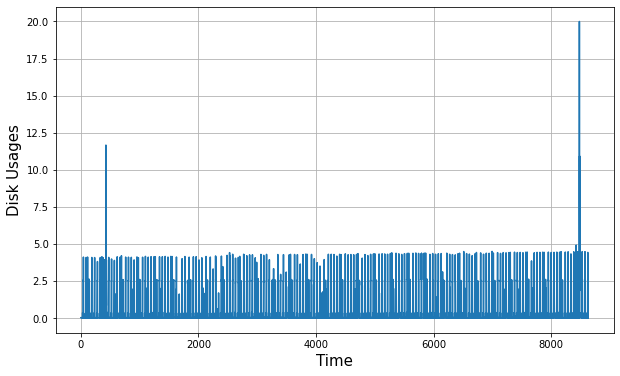

In [15]:
series = np.array(BW_usage)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
#plt.title("Bandwidth Usages dataset",fontsize=16)

plot_series(time, series)
 
plt.savefig('Raw_Data.png', dpi = 720)

# *Split dataset as train and validation set*

In [16]:
split_time = 7500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Plot test data (not mandetory):

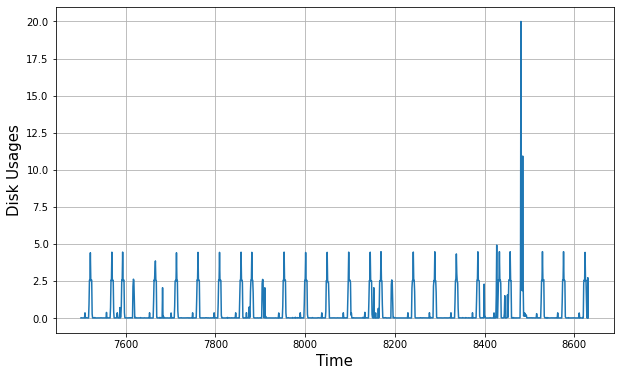

In [17]:
plt.figure(figsize=(10, 6))
#plt.title("Test Data",fontsize=16)
plot_series(time_valid, x_valid)
plt.savefig('test_data.png', dpi = 720) 

# Window function & forcasting funtion

In [18]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [19]:
#window function defination
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# forecasting function defination
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Finding Optimal Learning rate using "Huber Loss"

In [73]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 125
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(7500,)
Epoch 1/100
60/60 [==============================] - 13s 150ms/step - loss: 3.0502 - mae: 3.3932
Epoch 2/100
60/60 [==============================] - 9s 148ms/step - loss: 2.9864 - mae: 3.3249
Epoch 3/100
60/60 [==============================] - 9s 148ms/step - loss: 2.9354 - mae: 3.2805
Epoch 4/100
60/60 [==============================] - 9s 149ms/step - loss: 2.8531 - mae: 3.2038
Epoch 5/100
60/60 [==============================] - 9s 149ms/step - loss: 2.7992 - mae: 3.1576
Epoch 6/100
60/60 [==============================] - 9s 149ms/step - loss: 2.7356 - mae: 3.1027
Epoch 7/100
60/60 [==============================] - 9s 149ms/step - loss: 2.6660 - mae: 3.0448
Epoch 8/100
60/60 [==============================] - 9s 150ms/step - loss: 2.6068 - mae: 2.9997
Epoch 9/100
60/60 [==============================] - 9s 149ms/step - loss: 2.5481 - mae: 2.9522
Epoch 10/100
60/60 [=============

# Ploting learning rate vs Loss curve

In [74]:
# Checking what is in history data
print('\nhistory dict:', history.history)


history dict: {'loss': [3.0127599239349365, 2.9448964595794678, 2.878164768218994, 2.8134658336639404, 2.7500150203704834, 2.687680721282959, 2.6261374950408936, 2.564655065536499, 2.5012712478637695, 2.4339420795440674, 2.360854387283325, 2.281672716140747, 2.1956865787506104, 2.1020328998565674, 2.0026650428771973, 1.8978993892669678, 1.7876237630844116, 1.6716448068618774, 1.5509735345840454, 1.4273192882537842, 1.301169514656067, 1.172691822052002, 1.0443907976150513, 0.9184605479240417, 0.7997771501541138, 0.6930216550827026, 0.5996865034103394, 0.5185851454734802, 0.4501008093357086, 0.39075538516044617, 0.33720171451568604, 0.29114651679992676, 0.25536057353019714, 0.22905370593070984, 0.2109706550836563, 0.19944104552268982, 0.1932542771100998, 0.18991366028785706, 0.18772152066230774, 0.18595798313617706, 0.18439693748950958, 0.18293072283267975, 0.1814134567975998, 0.1798851191997528, 0.17828331887722015, 0.17659986019134521, 0.17485187947750092, 0.1727590411901474, 0.170468

Finding minimum loss:

In [75]:
min_loss=min(history.history["loss"])
min_loss_index=history.history["loss"].index(min_loss)
min_lr=(history.history["lr"])[min_loss_index]
min_lr


0.000112201844

ploting mimnimum loss point

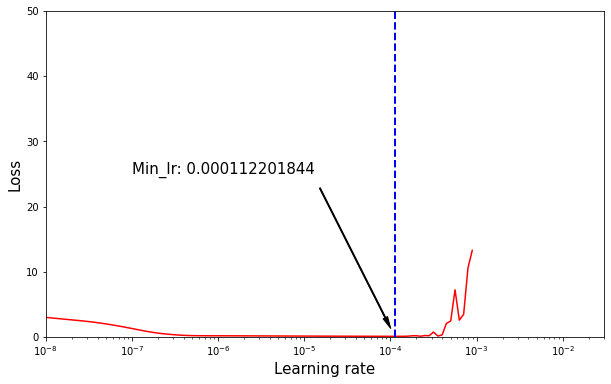

In [76]:
plt.figure(figsize=(10, 6))
plt.semilogx(history.history["lr"], history.history["loss"],'r')
plt.axis([1e-8, 3e-2, 0, 50])
plt.xlabel("Learning rate", fontsize=15)
plt.ylabel("Loss", fontsize=15)
#plt.grid()
s='Min_lr: '+str(min_lr)
plt.axvline(x=min_lr, linewidth=2,color="b",ls="--")
plt.annotate(s, xy=(min_lr, min_loss), xytext=(1E-7, 25),arrowprops=dict(facecolor='black', shrink=0.05 ,width=1.0, headwidth=5.0),fontsize=15)
#plt.savefig('lr_vs_loss.png', dpi = 720) 
plt.show()

# Training The Model 

In [91]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=124, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=65, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10)
])



optimizer = tf.keras.optimizers.SGD(min_lr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae","mse","msle","mape"])
history = model.fit(train_set,epochs=300)

Epoch 1/300
60/60 [==============================] - 13s 149ms/step - loss: 0.3147 - mae: 0.5195 - mse: 1.0712 - msle: 0.2081 - mape: 7077148.1230
Epoch 2/300
60/60 [==============================] - 9s 141ms/step - loss: 0.2856 - mae: 0.5059 - mse: 0.9236 - msle: 0.1686 - mape: 11058848.5164
Epoch 3/300
60/60 [==============================] - 9s 142ms/step - loss: 0.2727 - mae: 0.4910 - mse: 0.8588 - msle: 0.1523 - mape: 11244023.1803
Epoch 4/300
60/60 [==============================] - 9s 144ms/step - loss: 0.2631 - mae: 0.4810 - mse: 0.8079 - msle: 0.1442 - mape: 11362085.9344
Epoch 5/300
60/60 [==============================] - 9s 140ms/step - loss: 0.2566 - mae: 0.4697 - mse: 0.7779 - msle: 0.1376 - mape: 10351679.8607
Epoch 6/300
60/60 [==============================] - 9s 141ms/step - loss: 0.2500 - mae: 0.4663 - mse: 0.7451 - msle: 0.1329 - mape: 11264342.8361
Epoch 7/300
60/60 [==============================] - 9s 145ms/step - loss: 0.2440 - mae: 0.4599 - mse: 0.7199 - msle: 

In [92]:
#minimum mae error
min(history.history["mae"])

0.20629280805587769

model summary:

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 65)          390       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33280     
_________________________________________________________________
gru (GRU)                    (None, None, 64)          24960     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 15)          465       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           16        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

Forecasting workload

In [94]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

visualization of full workload prediction

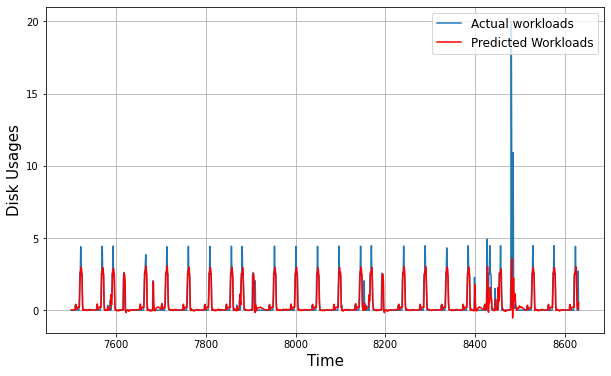

In [95]:
plt.figure(figsize=(10, 6))
#plt.title("Prediction of dataset",fontsize=16)

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast,'r' )
plt.legend(('Actual workloads', 'Predicted Workloads'),loc='upper right',fontsize=12)
plt.savefig('BW prediction.png', dpi = 720) 

Visualizing short time workload prediction

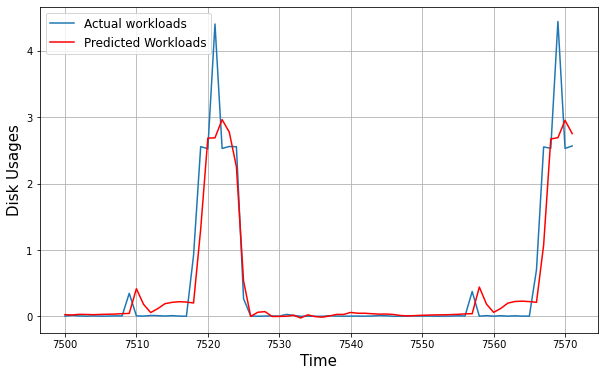

In [96]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[0:72], x_valid[0:72])
plot_series(time_valid[0:72], rnn_forecast[0:72],'r' )
plt.legend(('Actual workloads', 'Predicted Workloads'),fontsize=12)
plt.savefig('6 hr BW pred.png', dpi = 720) 

Visualizing medium time ahead workload prediction

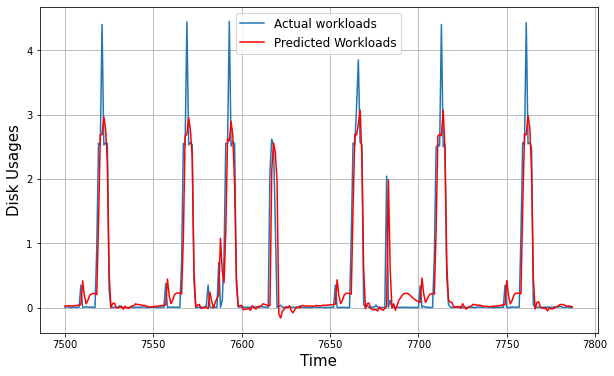

In [97]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[0:288], x_valid[0:288])
plot_series(time_valid[0:288], rnn_forecast[0:288],'r' )
plt.legend(('Actual workloads', 'Predicted Workloads'),fontsize=12)
plt.savefig('24 hr bw pred.png', dpi = 720) 

Visualization of long time ahead prediction

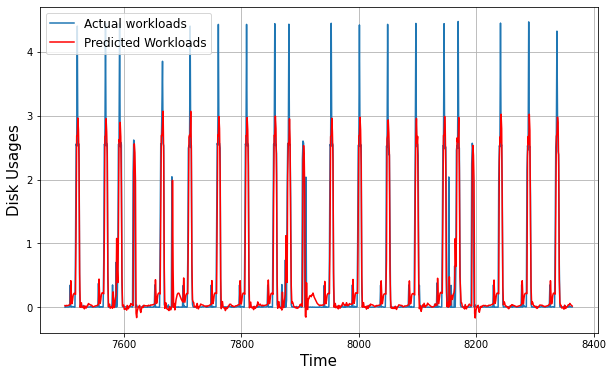

In [98]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[0:864], x_valid[0:864])
plot_series(time_valid[0:864], rnn_forecast[0:864],'r' )
plt.legend(('Actual workloads', 'Predicted Workloads'),fontsize=12)
plt.savefig('3 day disk pred.png', dpi = 720) 

# Error output

In [99]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.2589052

In [100]:
tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()

0.6309771

In [101]:
tf.keras.metrics.msle(x_valid, rnn_forecast).numpy()

0.05931422

In [102]:
tf.keras.metrics.mape(x_valid, rnn_forecast).numpy()

1524.1217

# Epoch vs Loss curve

In [103]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
valid_set = windowed_dataset(x_valid, window_size=64, batch_size=125, shuffle_buffer=shuffle_buffer_size)
history1 = model.fit(valid_set,epochs=300)

Epoch 1/300
9/9 [==============================] - 3s 152ms/step - loss: 0.1336 - mae: 0.2656 - mse: 0.6583 - msle: 0.0618 - mape: 1589.4811
Epoch 2/300
9/9 [==============================] - 1s 144ms/step - loss: 0.1332 - mae: 0.2630 - mse: 0.6568 - msle: 0.0616 - mape: 1526.6237
Epoch 3/300
9/9 [==============================] - 2s 149ms/step - loss: 0.1329 - mae: 0.2631 - mse: 0.6559 - msle: 0.0615 - mape: 1533.5662
Epoch 4/300
9/9 [==============================] - 2s 147ms/step - loss: 0.1327 - mae: 0.2639 - mse: 0.6552 - msle: 0.0614 - mape: 1564.9360
Epoch 5/300
9/9 [==============================] - 1s 145ms/step - loss: 0.1325 - mae: 0.2631 - mse: 0.6547 - msle: 0.0612 - mape: 1550.1157
Epoch 6/300
9/9 [==============================] - 1s 142ms/step - loss: 0.1323 - mae: 0.2637 - mse: 0.6536 - msle: 0.0613 - mape: 1579.5037
Epoch 7/300
9/9 [==============================] - 1s 144ms/step - loss: 0.1321 - mae: 0.2626 - mse: 0.6530 - msle: 0.0611 - mape: 1555.2611
Epoch 8/300
9

<Figure size 432x288 with 0 Axes>

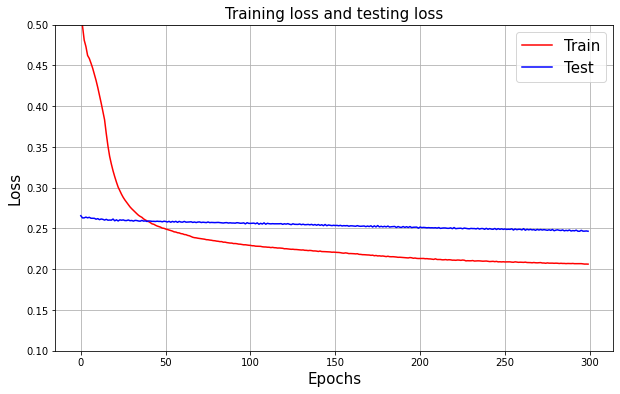

<Figure size 432x288 with 0 Axes>

In [104]:
val_loss=history1.history['mae']
loss=history.history['mae']
epoch=range(len(loss))
epochs=range(len(val_loss))

#zoomed_loss = loss[30:]
#zoomed_epoch = range(30,50)

#zoomed_val_loss = loss[30:]
#zoomed_epochs = range(30,50)
plt.figure(figsize=(10, 6))
#plt.xlim(0, 50)
plt.ylim(0.1,0.5 )
plt.plot(epoch, loss, 'r')
#plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.plot(epochs, val_loss, 'b')
#plt.plot(zoomed_epochs, zoomed_val_loss, 'r')
plt.title('Training loss and testing loss', fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend(['Train', 'Test'], fontsize=15)#, loc='upper left')
plt.grid()
plt.savefig('train vs test mae.png', dpi = 720) 
plt.figure()
#zoomed_loss = loss[200:]
#zoomed_epochs = range(200,300)

<Figure size 432x288 with 0 Axes>

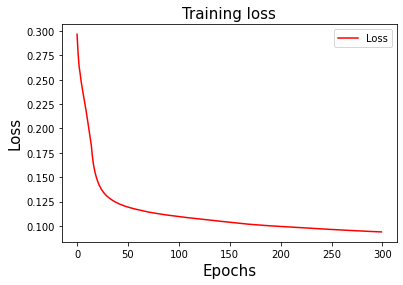

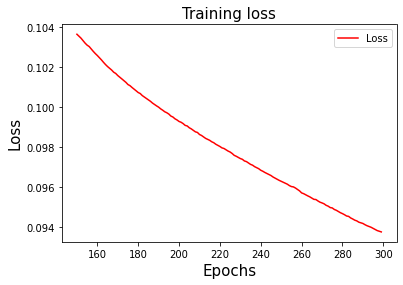

<Figure size 432x288 with 0 Axes>

In [105]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss', fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend(["Loss"])
plt.savefig('epoch_v_losss.png', dpi = 720) 
plt.figure()



zoomed_loss = loss[150:]
zoomed_epochs = range(150,300)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss', fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend(["Loss"])

plt.figure()